In [2]:
import math
import torch
import torchfields
import torch.nn.functional as F
from torchvision.utils import save_image

%matplotlib inline
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from torchvtk.utils import make_2d
from differender.volume_raycaster import Raycaster
from differender.utils import get_rand_pos, in_circles

[Taichi] version 0.8.1, llvm 10.0.0, commit cc2dd342, linux, python 3.9.7
[TaiGLSL] version 0.0.11


In [3]:
def get_view_mat(look_from, look_to=None, look_up=None, dtype=None):
    ''' Computes a view matrix based on camera parameters.
    Args:
        look_from (Tensor (BS, 3)): Batch of camera positions
        look_to (Tensor (BS, 3)): Batch of position vectors of the object of interest
        look_up (Tensor (BS, 3)): Batch of up vectors
    Returns:
        View matrix as torch Tensor of shape (BS, 3, 3). Uses device of `look_from`
    '''
    look_from = make_2d(look_from)
    bs, dev = look_from.size(0), look_from.device
    if look_up is None: look_up = F.normalize(torch.eye(3)[1].expand(bs, 3), dim=1).to(dev)
    else:               look_up = make_2d(look_up)
    if look_to is None: look_to = F.normalize(torch.zeros(3).expand( bs, 3), dim=1).to(dev)
    else:               look_to = make_2d(look_to)

    z = F.normalize(look_from - look_to, dim=1).expand(bs, 3)
    x = F.normalize(torch.cross(look_up, z), dim=1)
    y = torch.cross(x, -z, dim=1)
    ret = torch.eye(4)[None].expand(bs, -1, -1)
    ret[..., :3, :3] = torch.stack([x, y, z], dim=1)
    ret[..., :3,  3] = -torch.stack([torch.bmm(x.unsqueeze(-2), look_from.unsqueeze(-1)),
                                    torch.bmm(y.unsqueeze(-2), look_from.unsqueeze(-1)),
                                    torch.bmm(z.unsqueeze(-2), look_from.unsqueeze(-1))]).squeeze()
    return ret.to(dtype).squeeze(0)

def get_proj_mat(fov, aspect, near=0.1, far=5.0, dtype=None, device=None):
    ''' Computes a projection matrix according to inputs
    Args:
        fov (float): Field of View in radians (Full angle, no half-angle)
        aspect (float): Aspect ratio width/height of the viewport
        near (float): Near plane distance
        far (float): Far plane distance
        dtype (torch.dtype): Torch type to cast matrix to
        device (torch.device): Device to put matrix on
    Returns:
        Perspective projection matrix as torch tensor of shape (4,4)
    '''
    q = 1 / math.tan(fov * 0.5)
    a = q / aspect
    b = -(far + near) / (far - near)
    c = -(2*far*near) / (far - near)
    #c = - (far*near)/(far-near)

    return torch.tensor([[a, 0, 0, 0],
                         [0, q, 0, 0],
                         [0, 0, b, c],
                         [0, 0,-1, 0]]).to(dtype).to(device)

In [4]:
def depth2points(depth, fov=30, far=5.0):
    factor = 2.0 * torch.tan(torch.tensor([fov], dtype=depth.dtype, device=depth.device) / 2.0)  #  TODO: check
    aspect = depth.size(-2) / depth.size(-1)
    Y, X = torch.meshgrid(torch.arange(depth.size(-2), device=depth.device), torch.arange(depth.size(-1), device=depth.device))
    Y = factor * depth * (Y - depth.size(-2)/2.0) / depth.size(-2)
    X = factor * depth * (X - depth.size(-1)/2.0) / depth.size(-1)
    coords = torch.stack([X, Y, -depth*far])
    return coords

def depth2pointz(depth, fov=30, far=5.0):
    X, Y = torch.meshgrid(torch.linspace(-1,1, depth.size(-1)), torch.linspace(-1,1, depth.size(-2)), indexing='xy')
    coords = torch.stack([X, Y, 2*depth-1.0])
    return coords

def homogenize(t, dim=0):
    shap, dev, typ = list(t.shape), t.device, t.dtype
    shap[dim] = 1
    return torch.cat([t, torch.ones(shap, device=dev, dtype=typ)], dim=dim)

def composite_layers(layers):
    ''' Composites SORTED (batch of) RBAD layers

    Args:
        layers (torch.Tensor): ([BS,] L, 4+, H, W) RGBAD image stack of L layers, sorted by depth, can have more than RGBA channels, but they are ignored

    Returns:
        torch.Tensor: ([BS,], 4, H, W) (batch of) RGBA composited render
    '''
    l_dim, c_dim = layers.ndim - 4, layers.ndim - 3
    l_size = layers.size(l_dim)
    devdtype = {'dtype': layers.dtype, 'device': layers.device}

    shap_rgb = (*layers.shape[:-3], 3, *layers.shape[-2:])
    shap_a   = (*layers.shape[:-3], 1, *layers.shape[-2:])
    # Shapes are ([BS,] L, 3, H, W) and ([BS,], L, 1, H, W)
    acc_rgb, acc_a = torch.zeros(*shap_rgb, **devdtype), torch.zeros(*shap_a, **devdtype)
    acc_rgb[..., 0, :,:,:] = layers[..., 0,  :3, :,:]
    acc_a[  ..., 0, :,:,:] = layers[..., 0, [3], :,:]
    for i in range(1, l_size):
        #                                   old acc       +           (1 - a)              *          Alpha           *          Color
        acc_rgb[..., i, :,:,:] = acc_rgb[..., i-1, :,:,:] + (1.0 - acc_a[..., i-1, :,:,:]) * layers[..., i, [3], :,:] * layers[..., i, :3, :,:]
        acc_a[  ..., i, :,:,:]   = acc_a[..., i-1, :,:,:] + (1.0 - acc_a[..., i-1, :,:,:]) * layers[..., i, [3], :,:]
    acc_rgba = torch.cat([acc_rgb[..., -1, :,:,:], acc_a[..., -1, :,:,:]], dim=c_dim-1) # Layer dim is removed, thus c_dim -1
    return torch.clamp(acc_rgba, 0.0, 1.0)

In [5]:
def transform_from_to(pts, view1, view2, proj):
    ''' Transforms `pts` from NDC in `view1` to NDC in `view2` using common projection matrix `proj`
    
    Args:
        pts (torch.Tensor): Points to transform. Shape (N, 4) (homogeneous coordinates)
        view1 (torch.Tensor): View matrix from which `pts` are currently viewed from. Shape (4, 4)
        view2 (torch.Tensor): View matrix to transform `pts` to. Shape (4, 4)
        proj (torch.Tensor): Projection matrix. Shape (4, 4)
        
    Returns:
        torch.Tensor: Transformed points in NDC space viewed from `view2` perspective. Shape (N, 4)
    '''
    pts_v1 = torch.einsum('rc,nc->nr', (proj.inverse(), pts))
    pts_v1 /= pts_v1[...,[3]].clone()
    fused = proj @ view2 @ view1.inverse()
    tfmd = torch.einsum('rc,nc->nr', (fused, pts_v1))
    tfmd /= tfmd[:, [3]].clone()
    return tfmd

In [71]:
data = torch.load('/run/media/dome/Data/data/stdepth_test/CQ500-CT-62_40.pt')
rgba = data['rgba'].float()
scale_factor = 0.25
up_factor = -round(math.log(scale_factor, 2.0))
depth = F.interpolate(data['layer1'][-1].float()[None,None], scale_factor=0.5).squeeze()
fh = F.interpolate(data['layer3'][-1].float()[None,None], scale_factor=0.5).squeeze()
front = data['layer1'][:4].float()
back  = data['back'][:4].float()
points = depth2pointz(depth)
fh_points = depth2pointz(fh)

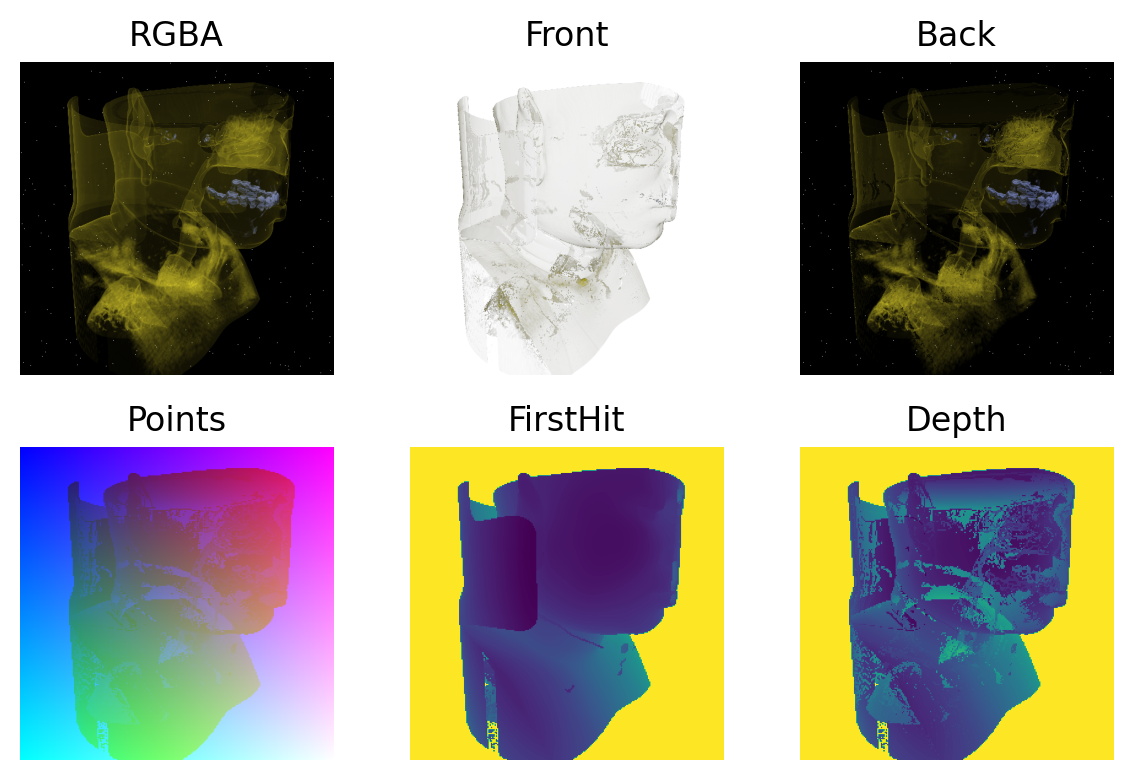

In [72]:
fig, ax = plt.subplots(2,3,dpi=200, tight_layout=True)
ax[0,0].imshow(rgba.permute(1,2,0))
ax[0,1].imshow(front.permute(1,2,0))
ax[0,2].imshow(back.permute(1,2,0))
ax[1,0].imshow(points.permute(1,2,0) * 0.5 + 0.5)
ax[1,1].imshow(fh)
ax[1,2].imshow(depth)
ax[0,0].set_title('RGBA')
ax[0,1].set_title('Front')
ax[0,2].set_title('Back')
ax[1,0].set_title('Points')
ax[1,1].set_title('FirstHit')
ax[1,2].set_title('Depth')
for x in ax.reshape(-1): x.set_axis_off()

In [73]:
homo_points = homogenize(points).permute(1,2,0).reshape(-1, 4)
homo_points_fh = homogenize(fh_points).permute(1,2,0).reshape(-1, 4)
homo_points.shape

torch.Size([65536, 4])

In [74]:
view1 = get_view_mat(torch.Tensor([0,   0,  2.7]))
view2 = get_view_mat(torch.Tensor([0.01, 0,  2.7]))
proj  = get_proj_mat(fov=torch.deg2rad(torch.Tensor([60.0])), aspect=1.0)
pts_front = transform_from_to(homo_points_fh, view1, view2, proj)
pts_back  = transform_from_to(homo_points,    view1, view2, proj)
pts_front_im = pts_front.reshape(depth.size(-2), depth.size(-1), 4).permute(2,0,1)
pts_back_im  =  pts_back.reshape(depth.size(-2), depth.size(-1), 4).permute(2,0,1)

In [75]:
pts_v1 = torch.einsum('rc,nc->nr', (proj.inverse(), pts_back))
print('View1 w/o zdiv')
print(f'  z in ({pts_v1[:, 2].min().item():.3f}, {pts_v1[:, 2].max().item():.3f})')
print(f'  w in ({pts_v1[:, 3].min().item():.3f}, {pts_v1[:, 3].max().item():.3f})')
print(f'  xy between ({pts_v1[:, 0].min().item():.3f}, {pts_v1[:, 1].min().item():.3f})  and  ({pts_v1[:, 0].max().item():.3f}, {pts_v1[:, 1].max().item():.3f})')

pts_v1 /= pts_v1[...,[3]].clone()
print('\nView1 w/ zdiv')
print(f'  z in ({pts_v1[:, 2].min().item():.3f}, {pts_v1[:, 2].max().item():.3f})')
print(f'  w in ({pts_v1[:, 3].min().item():.3f}, {pts_v1[:, 3].max().item():.3f})')
print(f'  xy between ({pts_v1[:, 0].min().item():.3f}, {pts_v1[:, 1].min().item():.3f})  and  ({pts_v1[:, 0].max().item():.3f}, {pts_v1[:, 1].max().item():.3f})')

pts_w = torch.einsum('rc,nc->nr', (view1.inverse(), pts_v1))
print(f'\nWORLD\n  z in ({pts_w[:, 2].min().item():.3f}, {pts_w[:, 2].max().item():.3f})\n  w in ({pts_w[:, 3].min().item():.3f}, {pts_w[:, 3].max().item():.3f})')
print(f'  xy between ({pts_w[:, 0].min().item():.3f}, {pts_w[:, 1].min().item():.3f})  and  ({pts_w[:, 0].max().item():.3f}, {pts_w[:, 1].max().item():.3f})')

pts_v2 = torch.einsum('rc,nc->nr', (view2, pts_w))
print('\nView2')
print(f'  z in ({pts_v2[:, 2].min().item():.3f}, {pts_v2[:, 2].max().item():.3f})')
print(f'  w in ({pts_v2[:, 3].min().item():.3f}, {pts_v2[:, 3].max().item():.3f})')
print(f'  xy between ({pts_v2[:, 0].min().item():.3f}, {pts_v2[:, 1].min().item():.3f})  and  ({pts_v2[:, 0].max().item():.3f}, {pts_v2[:, 1].max().item():.3f})')

tfmd = torch.einsum('rc,nc->nr', (proj, pts_v2))
print('\nProj2 w/o zdiv')
print(f'  z in ({tfmd[:, 2].min().item():.3f}, {tfmd[:, 2].max().item():.3f})')
print(f'  w in ({tfmd[:, 3].min().item():.3f}, {tfmd[:, 3].max().item():.3f})')
print(f'  xy between ({tfmd[:, 0].min().item():.3f}, {tfmd[:, 1].min().item():.3f})  and  ({tfmd[:, 0].max().item():.3f}, {tfmd[:, 1].max().item():.3f})')

tfmd /= tfmd[:, [3]].clone()
print('\nProj2 w/ zdiv')
print(f'  z in ({tfmd[:, 2].min().item():.3f}, {tfmd[:, 2].max().item():.3f})')
print(f'  w in ({tfmd[:, 3].min().item():.3f}, {tfmd[:, 3].max().item():.3f})')
print(f'  xy between ({tfmd[:, 0].min().item():.3f}, {tfmd[:, 1].min().item():.3f})  and  ({tfmd[:, 0].max().item():.3f}, {tfmd[:, 1].max().item():.3f})')

pts_p2im = tfmd.reshape(depth.size(0), depth.size(1), -1).permute(2,0,1)

View1 w/o zdiv
  z in (-1.000, -1.000)
  w in (0.200, 6.672)
  xy between (-0.574, -0.579)  and  (0.580, 0.579)

View1 w/ zdiv
  z in (-5.011, -0.150)
  w in (1.000, 1.000)
  xy between (-2.878, -2.887)  and  (2.895, 2.887)

WORLD
  z in (-2.311, 2.550)
  w in (1.000, 1.000)
  xy between (-2.878, -2.887)  and  (2.895, 2.887)

View2
  z in (-5.021, -0.150)
  w in (1.000, 1.000)
  xy between (-2.870, -2.887)  and  (2.904, 2.887)

Proj2 w/o zdiv
  z in (-0.048, 5.022)
  w in (0.150, 5.021)
  xy between (-4.970, -5.000)  and  (5.029, 5.000)

Proj2 w/ zdiv
  z in (-0.320, 1.000)
  w in (1.000, 1.000)
  xy between (-0.990, -1.004)  and  (1.010, 1.004)


In [76]:
push_field_map = pts_p2im[:2].unsqueeze(0).clamp(-1,1).field()
nu_depth = pts_p2im[2]
push_field = push_field_map.from_mapping()
pull_field = push_field.inverse()

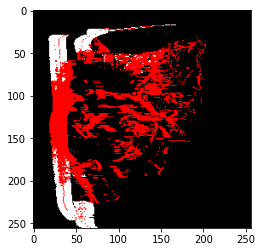

In [77]:
id_field = pull_field(push_field)
is_id = id_field.is_identity(eps=1e-4)
if is_id.all():
    print('Identity!')
else:
    where_wrong = id_field.abs() > 1e-4
    plt.imshow(where_wrong[0, [0,1,1]].permute(1,2,0).float())

In [78]:
color2 = pull_field.up(up_factor).sample(rgba)

In [79]:
color3 = push_field.up(up_factor).sample(rgba)

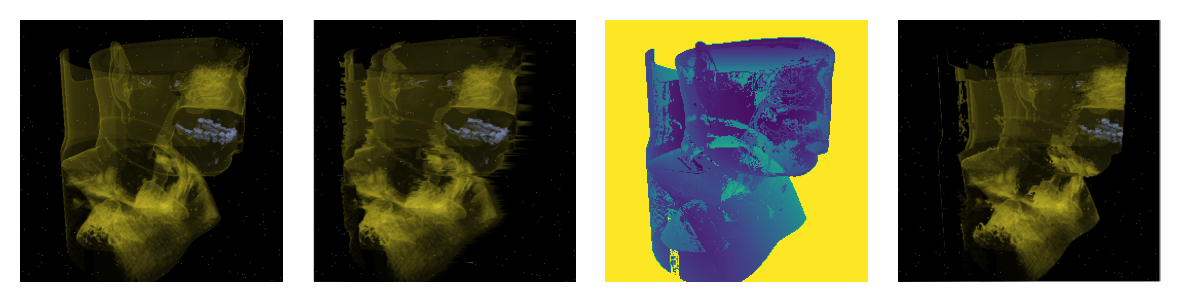

In [80]:
fig, ax = plt.subplots(1,4, dpi=200, tight_layout=True)
ax[0].imshow(rgba.permute(1,2,0))
ax[1].imshow(color2.permute(1,2,0))
ax[2].imshow(nu_depth)
ax[3].imshow(color3.permute(1,2,0))
for x in ax: x.set_axis_off()

In [81]:
lfs = [torch.Tensor([0,0, 2.7]) + in_circles(math.pi/2 + t, y=0, dist=0.007)[[0,2,1]] for t in torch.linspace(0.0, math.pi*2, 240)]

In [ ]:
# GIF me
fronts, backs = [], []
rgbas1, rgbas2 = [], []
for lf in lfs:
    view2 = get_view_mat(lf)
    pts_front = transform_from_to(homo_points_fh, view1, view2, proj)
    pts_back  = transform_from_to(homo_points,    view1, view2, proj)
    pts_front_im = pts_front.reshape(depth.size(-2), depth.size(-1), 4).permute(2,0,1)
    pts_back_im  =  pts_back.reshape(depth.size(-2), depth.size(-1), 4).permute(2,0,1)
    
    front_pull_field = pts_front_im[:2].unsqueeze(0).field().from_mapping().inverse()
    back_pull_field  =  pts_back_im[:2].unsqueeze(0).field().from_mapping().inverse()
    
    fronts.append(front_pull_field.up(up_factor).sample(front))
    backs.append(back_pull_field.up(up_factor).sample(back))
    rgbas1.append(front_pull_field.up(up_factor).sample(rgba))
    rgbas2.append(back_pull_field.up(up_factor).sample(rgba))
layerstack = torch.stack([torch.stack(fronts), torch.stack(backs)], dim=1)
images = composite_layers(layerstack)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), tight_layout=True)
ax.set_axis_off()
im = ax.imshow(images[0, :3].permute(1,2,0))
def animate(frame_num):
    im.set_data(images[frame_num, :3].permute(1,2,0))
    return im
anim = FuncAnimation(fig, animate, frames=len(images), interval=20)
HTML(anim.to_html5_video())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


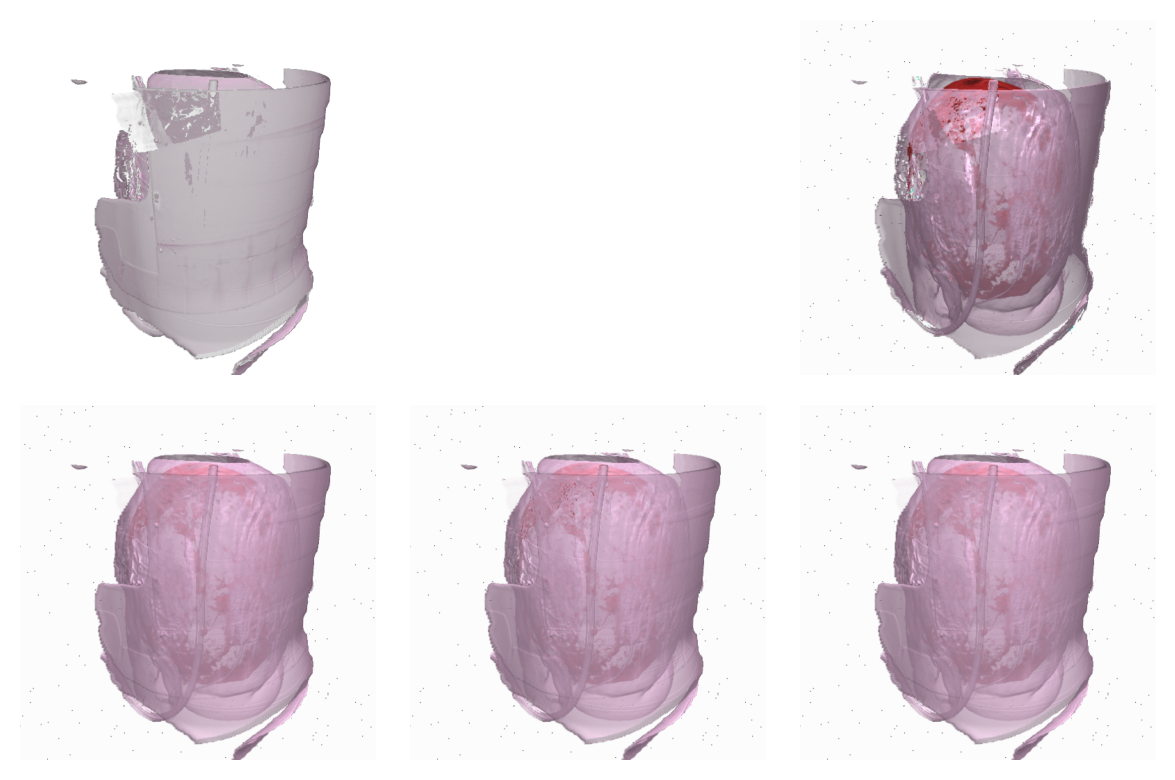

In [299]:
IDX = 50
fig, ax = plt.subplots(2,3,dpi=200, tight_layout=True)
for x in ax.reshape(-1): x.set_axis_off()
ax[0,0].imshow(fronts[IDX].permute(1,2,0))
ax[0,2].imshow(backs[IDX].permute(1,2,0))
ax[1,0].imshow(rgbas1[IDX].permute(1,2,0))
ax[1,1].imshow(images[IDX].permute(1,2,0))
ax[1,2].imshow(rgbas2[IDX].permute(1,2,0))

In [283]:
for i, im in enumerate(images): 
    save_image(im, f'gif_temp/{i:03d}.png')
!ffmpeg -framerate 30 -y -i gif_temp/%03d.png -c:v copy out.mp4
!rm gif_temp/*

ffmpeg version n5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12.2.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 -

In [74]:
torch.zeros_like(push_field_map[[0]]).shape

torch.Size([1, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


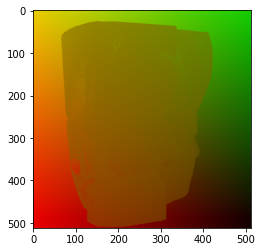

In [11]:
plt.imshow(torch.cat([push_field_map*0.5+0.5, torch.zeros_like(push_field_map[[0]])], dim=0).permute(1,2,0))

In [12]:
push_field

field([[[[ 1.8588,  1.8515,  1.8442,  ..., -1.8409, -1.8481, -1.8554],
         [ 1.8587,  1.8515,  1.8442,  ..., -1.8408, -1.8481, -1.8554],
         [ 1.8587,  1.8514,  1.8442,  ..., -1.8408, -1.8481, -1.8553],
         ...,
         [ 1.8444,  1.8372,  1.8300,  ..., -1.8267, -1.8339, -1.8411],
         [ 1.8444,  1.8371,  1.8299,  ..., -1.8266, -1.8338, -1.8411],
         [ 1.8443,  1.8371,  1.8299,  ..., -1.8266, -1.8338, -1.8410]],

        [[ 1.6220,  1.6220,  1.6220,  ...,  1.6220,  1.6220,  1.6220],
         [ 1.6148,  1.6148,  1.6148,  ...,  1.6148,  1.6148,  1.6148],
         [ 1.6075,  1.6075,  1.6075,  ...,  1.6075,  1.6075,  1.6075],
         ...,
         [-2.0583, -2.0583, -2.0583,  ..., -2.0583, -2.0583, -2.0583],
         [-2.0654, -2.0654, -2.0654,  ..., -2.0654, -2.0654, -2.0654],
         [-2.0726, -2.0726, -2.0726,  ..., -2.0726, -2.0726, -2.0726]]]])

In [25]:
rgba_v2 = displacement_field.inverse().sample(rgba)

In [26]:
rgba_v2.shape

torch.Size([4, 512, 512])

In [29]:
rgba_v2.min()

tensor(0.)

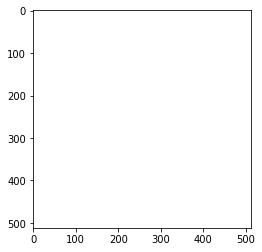

In [27]:
plt.imshow(rgba_v2.permute(1,2,0))

In [58]:
proj, view1, view2

(tensor([[ 3.7321,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  3.7321,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0408, -0.2041],
         [ 0.0000,  0.0000, -1.0000,  0.0000]]),
 tensor([[ 1.0000,  0.0000,  0.0000, -0.0000],
         [ 0.0000,  1.0000,  0.0000, -0.0000],
         [ 0.0000,  0.0000,  1.0000, -2.7000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]),
 tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00],
         [ 0.0000e+00,  9.9931e-01, -3.7012e-02,  7.4506e-09],
         [ 0.0000e+00,  3.7012e-02,  9.9931e-01, -2.7019e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]))

In [59]:
pts_v1 = torch.einsum('rc,nc->nr', (proj.inverse(), homo_points))
pts_v1[...,3] = 1.0
pts_w  = torch.einsum('rc,nc->nr', (view1.inverse(), pts_v1))
pts_v2 = torch.einsum('rc,nc->nr', (view2, pts_w))
pts_p2 = torch.einsum('rc,nc->nr', (proj, pts_v2))
pts_p2 /= pts_p2[..., [3]]
'Proj1:', homo_points[:5], 'View1:', pts_v1[:5], 'World:', pts_w[:5], 'View2:', pts_v2[:5], 'Proj2:', pts_p2[:5]

('Proj1:',
 tensor([[ 0.8560,  0.8560, -5.0000,  1.0000],
         [ 0.8526,  0.8560, -5.0000,  1.0000],
         [ 0.8493,  0.8560, -5.0000,  1.0000],
         [ 0.8460,  0.8560, -5.0000,  1.0000],
         [ 0.8426,  0.8560, -5.0000,  1.0000]]),
 'View1:',
 tensor([[ 0.2294,  0.2294, -1.0000,  1.0000],
         [ 0.2285,  0.2294, -1.0000,  1.0000],
         [ 0.2276,  0.2294, -1.0000,  1.0000],
         [ 0.2267,  0.2294, -1.0000,  1.0000],
         [ 0.2258,  0.2294, -1.0000,  1.0000]]),
 'World:',
 tensor([[0.2294, 0.2294, 1.7000, 1.0000],
         [0.2285, 0.2294, 1.7000, 1.0000],
         [0.2276, 0.2294, 1.7000, 1.0000],
         [0.2267, 0.2294, 1.7000, 1.0000],
         [0.2258, 0.2294, 1.7000, 1.0000]]),
 'View2:',
 tensor([[ 0.2294,  0.1663, -0.9945,  1.0000],
         [ 0.2285,  0.1663, -0.9945,  1.0000],
         [ 0.2276,  0.1663, -0.9945,  1.0000],
         [ 0.2267,  0.1663, -0.9945,  1.0000],
         [ 0.2258,  0.1663, -0.9945,  1.0000]]),
 'Proj2:',
 tensor([[0.8607,

In [ ]:
def change_viewpoint(image, depth, view1, view2, proj, max_depth=5.0):
    pts_flat = depth2points(depth, fov=30, far=max_depth).permute(1,2,0).reshape(-1)
    

In [125]:
view_new = get_view_mat(torch.Tensor([0,0.5,2.7]))[0]
pts_v1 = torch.einsum('rc,nc->nr', (proj_mat.inverse(), homo_points))
pts_w  = torch.einsum('rc,nc->nr', (view_.inverse(), pts_v1))
pts_v2 = torch.einsum('rc,nc->nr', (view_new, pts_w))
pts_p2 = torch.einsum('rc,nc->nr', (proj_mat, pts_v2))
pts_p2 /= pts_p2[:, [3]].clone()
'Proj1:', homo_points[:5], 'View1:', pts_v1[:5], 'World:', pts_w[:5], 'View2:', pts_v2[:5], 'Proj2:', pts_p2[:5]

('Proj1:',
 tensor([[0.8560, 0.8560, 1.0000, 1.0000],
         [0.8526, 0.8560, 1.0000, 1.0000],
         [0.8493, 0.8560, 1.0000, 1.0000],
         [0.8460, 0.8560, 1.0000, 1.0000],
         [0.8426, 0.8560, 1.0000, 1.0000]]),
 'View1:',
 tensor([[ 0.2294,  0.2294, -1.0000,  0.0100],
         [ 0.2285,  0.2294, -1.0000,  0.0100],
         [ 0.2276,  0.2294, -1.0000,  0.0100],
         [ 0.2267,  0.2294, -1.0000,  0.0100],
         [ 0.2258,  0.2294, -1.0000,  0.0100]]),
 'World:',
 tensor([[ 0.2294,  0.2294, -0.9730,  0.0100],
         [ 0.2285,  0.2294, -0.9730,  0.0100],
         [ 0.2276,  0.2294, -0.9730,  0.0100],
         [ 0.2267,  0.2294, -0.9730,  0.0100],
         [ 0.2258,  0.2294, -0.9730,  0.0100]]),
 'View2:',
 tensor([[ 0.2294,  0.4027, -0.9424,  0.0100],
         [ 0.2285,  0.4027, -0.9424,  0.0100],
         [ 0.2276,  0.4027, -0.9424,  0.0100],
         [ 0.2267,  0.4027, -0.9424,  0.0100],
         [ 0.2258,  0.4027, -0.9424,  0.0100]]),
 'Proj2:',
 tensor([[0.9083,

In [ ]:
pts_wrld = torch.einsum('rc,nr->nc', (view_proj[0], homo_points))

In [150]:
fused_mat = proj_mat @ view_mat @ view_new.inverse() @ proj_mat.inverse()

In [155]:
tfmd_sample_locs = torch.einsum('rc,nc->nr', (fused_mat, sample_locs_homo)).reshape(*sample_locs.shape[:2], 4)[..., :2]
tfmd_sample_locs.shape

torch.Size([512, 512, 2])

In [148]:
pts_p2_fus = torch.einsum('rc,nc->nr', (fused_mat, homo_points))
pts_p2_fus /= pts_p2_fus[:, [3]].clone()
pts_p2_fus[:5]

tensor([[0.9083, 1.5947, 0.9999, 1.0000],
        [0.9047, 1.5947, 0.9999, 1.0000],
        [0.9012, 1.5947, 0.9999, 1.0000],
        [0.8976, 1.5947, 0.9999, 1.0000],
        [0.8941, 1.5947, 0.9999, 1.0000]])

In [153]:
X, Y = torch.meshgrid(
    torch.linspace(-1,1,points.size(-1)), torch.linspace(-1,1,points.size(-2)), indexing='xy')
sample_locs = torch.stack([X, Y], dim=-1)
sample_locs_homo = torch.cat([sample_locs, torch.zeros_like(sample_locs)[...,[0]], torch.ones_like(sample_locs)[..., [0]]], dim=-1).reshape(-1, 4)
sample_locs.shape, sample_locs_homo.shape

(torch.Size([512, 512, 2]), torch.Size([262144, 4]))

In [170]:
def plot_hist(t, bins=256, return_fig=False):
    mi, ma = t.min(), t.max()
    x = torch.linspace(mi, ma, bins)
    hist = t.histc(bins=bins)
    fig, ax = plt.subplots(1,1, dpi=200)
    ax.bar(x, hist.cpu().float(), align='center')
    if return_fig: return fig

In [191]:
resamp2 = F.grid_sample(color[None], pts_p2[...,:2].reshape(512,512,2)[None], mode='nearest')[0]

In [79]:
merged = torch.cat([points, (data['rgba'].float() * 255.0).to(torch.uint8)], dim=0)
points_flat = points.permute(1,2,0).reshape(-1, 3)
colors_flat = (data['rgba'].float() * 255.0).to(torch.uint8).permute(1,2,0).reshape(-1, 4)
print(merged.shape)
ply_list = [" ".join(map(str, p)) + " " + " ".join(map(str, c)) for p,c in zip(points_flat.tolist(), colors_flat.tolist())]

torch.Size([7, 512, 512])


In [81]:
ply_str = "\n".join(ply_list)

In [82]:
with open('temp.ply', 'w') as f:
     f.write(f'''ply
format ascii 1.0
element vertex {len(ply_list)}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
property uchar alpha
end_header
{ply_str}
''')